In [199]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import platform
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from skimage import morphology, feature, transform, filters

In [770]:
from shapes import *
from detect_bubbles import *
from utils import *

In [304]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
platform.system()

'Windows'

In [6]:
plat = platform.system()
if plat == "Darwin":
    calib_dir =  "/Users/Habib/Google Drive/Uni Heidelberg/11 WS 2017-2018/Masterarbeit/Messungen/Reihe_32_calib_radius" 
elif plat == "Windows":
    calib_dir = "../Messungen/Reihe_32_calib_radius/"

In [7]:
cim = []
bgim = []
filenames = []
for file in os.listdir(calib_dir):
    filenames.append(file)

filenames.sort() # sort after creation date since date is in the name

In [212]:
cim = []
bgim = []
for file in filenames[1:]:
    if int(file[-5:-4])%2 ==0:
        img = cv2.imread(os.path.join(calib_dir, file), 0)
        cim.append(img)
    else:
        img = cv2.imread(os.path.join(calib_dir, file), 0)
        bgim.append(img)

In [128]:
"""
for idx, im in enumerate(cim):
    cv2.imwrite(os.path.join(calib_dir, "redlit", str(idx)+".bmp"), im)
for idx, im in enumerate(bgim):
    cv2.imwrite(os.path.join(calib_dir, "greenlit", str(idx)+".bmp"), im)
"""

In [76]:
track_dir = "data/tracking_data/"
red_tracks = [np.loadtxt(os.path.join(track_dir, file)) for file in os.listdir(track_dir) if file.startswith("red")]
green_tracks = [np.loadtxt(os.path.join(track_dir, file)) for file in os.listdir(track_dir) if file.startswith("green")]

In [77]:
red_tracks[0].T

array([[  0.        ,   1.        ,   2.        ,   3.        ,
          4.        ,   5.        ,   6.        ,   7.        ,
          8.        ,   9.        ,  10.        ,  11.        ,  12.        ],
       [  0.27324533,   0.27324533,   0.32679194,   0.37797624,
          0.43574923,   0.49780005,   0.56459671,   0.63574958,
          0.70964873,   0.78301591,   0.85510844,   0.92646062,
          0.99733114],
       [  0.15512778,   0.15512778,   0.22048618,   0.28899437,
          0.35803697,   0.42713082,   0.49578801,   0.56197411,
          0.62439066,   0.68408263,   0.74258208,   0.80154854,
          0.86454457]])

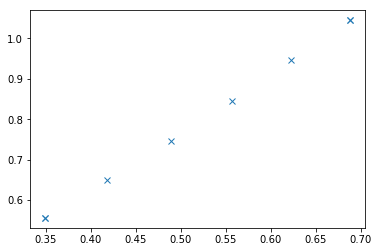

In [78]:
curr_tr = red_tracks[1].T
plt.plot(curr_tr[1] , curr_tr[2], 'x')

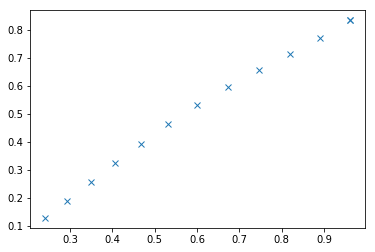

In [80]:
curr_tr = green_tracks[1].T
plt.plot(curr_tr[1] , curr_tr[2], 'x')

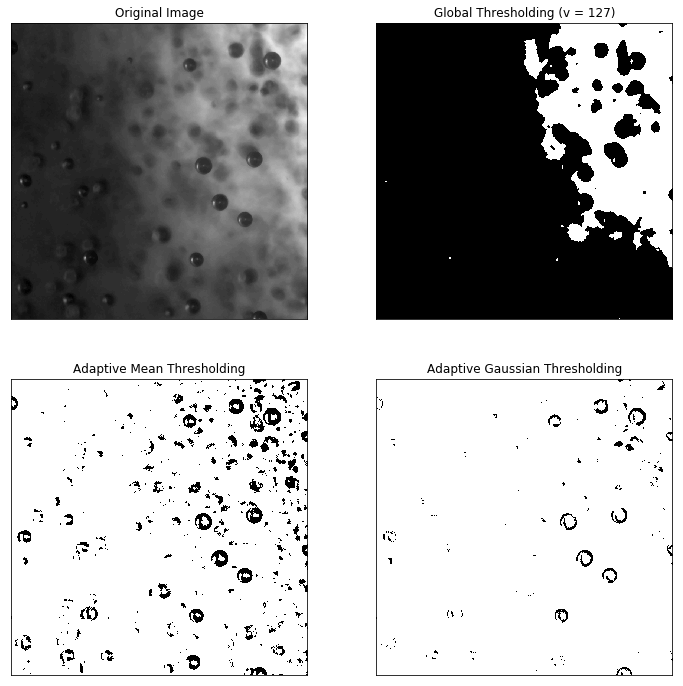

In [90]:
import cv2 as cv
img = bgim[0]
img = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img,60,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,21,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,31,3)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

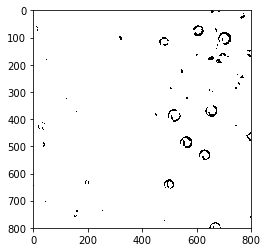

In [108]:
plt.imshow(morphology.closing(th3), cmap="gray")

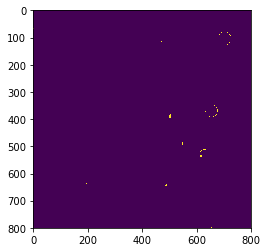

In [106]:
plt.imshow(feature.canny(img, sigma=0.2))

In [136]:
p = Point(0.2679566740989685*800, 0.20746062695980072*800)

In [138]:
a = ll_to_ul(p, 800)

In [141]:
p.get_coord()

(214.3653392791748, 165.96850156784058)

In [142]:
a.get_coord()

(214.3653392791748, 634.0314984321594)

In [215]:
img = bgim[0]
window_size = 30

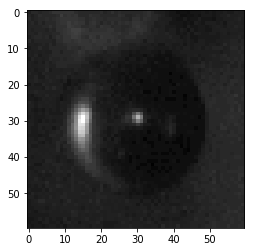

In [216]:
green_bubble = img[int(a.y-window_size):int(a.y+window_size), int(a.x-window_size):int(a.x+window_size)]
plt.imshow(green_bubble, cmap="gray")

In [170]:
from skimage.filters import try_all_threshold

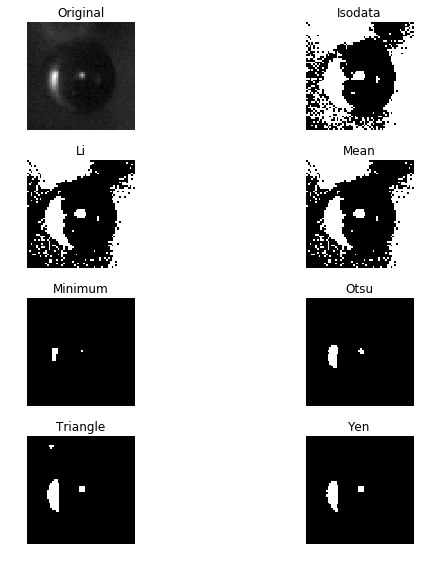

In [171]:
fig, ax = try_all_threshold(green_bubble, figsize=(10, 8), verbose=False)
plt.show()

In [175]:
vert_signal = green_bubble[:, int(green_bubble.shape[1]/2)]

(30, 50)

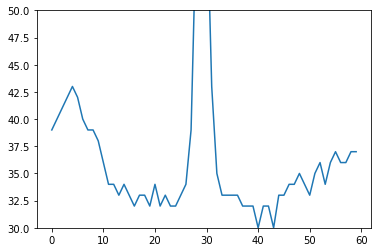

In [179]:
plt.plot(vert_signal)
plt.ylim(30,50)

In [230]:
from skimage.draw import circle_perimeter

In [382]:
edges = filters.sobel(green_bubble)
# Detect two radii
hough_radii = np.arange(10, 35, 1)
hough_res = transform.hough_circle(edges, hough_radii)

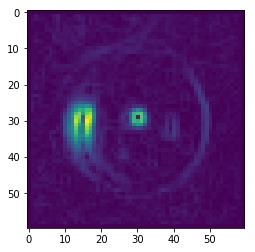

In [383]:
plt.imshow(edges)

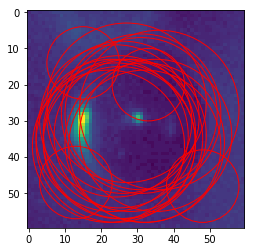

In [384]:
accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=20)

res_circles = []
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
for center_y, center_x, radius in zip(cy, cx, radii):
    res_circles.append(Circle(center_x, center_y, radius))
    ax.add_patch(patches.Circle((center_y, center_x), radius, color="red", fill=False))
plt.imshow(green_bubble)

In [385]:
avg_x = np.mean([circ.x for circ in res_circles])
avg_y = np.mean([circ.y for circ in res_circles])
avg_r = np.mean([circ.radius for circ in res_circles])

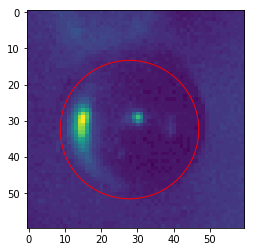

In [386]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.add_patch(patches.Circle((avg_y, avg_x), avg_r, fill=False, color='r'))
plt.imshow(green_bubble)
            

In [315]:
a.get_coord()

(214.3653392791748, 634.0314984321594)

In [313]:
subimg = extract_pad_image(bgim[0], Point(a.y, a.x), window_size=60, pad_mode="constant")

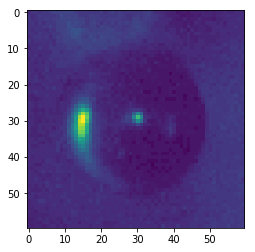

In [314]:
plt.imshow(subimg)

In [377]:
c = green_bubble_one(subimg, hough_radii=np.arange(20,35,1), total_num_peaks=10, max_offset=10)

In [444]:
c.radius

21.100000000000001

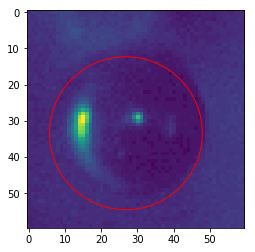

In [378]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.add_patch(patches.Circle((c.y, c.x), c.radius, fill=False, color='r'))
plt.imshow(subimg)

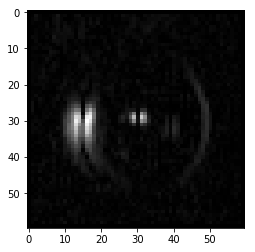

In [392]:
gb_grad = np.abs(filters.scharr_v(green_bubble))
plt.imshow(gb_grad, cmap="gray")

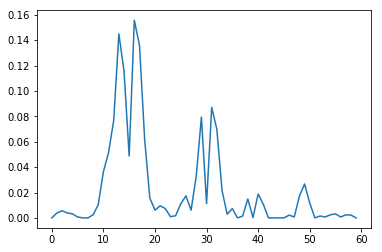

In [516]:
signal = gb_grad[30, :]
plt.plot(signal)

In [455]:
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter1d

argrelextrema(gaussian_filter1d(signal, sigma=2), np.greater)

(array([ 2, 15, 31, 39, 49], dtype=int64),)

# Calibration

In [634]:
tracks = []
for file in os.listdir(track_dir):
    if file.endswith(".csv"):
        path = os.path.join(track_dir, file)
        tracks += [get_tracking_data(path, bgim[0].shape)]
        

##  1. Green bubbles

In [791]:
radii = []
sub_images = []
res_circles = []
for tr in tracks:
    for marker in tr:
        if marker.frame != 0:
            subimg = extract_pad_image(bgim[int(marker.frame)-1], Point(marker.y, marker.x), window_size=60, pad_mode="constant")
            sub_images.append(subimg)
            res_circ = green_bubble_one(subimg, method="hough", hough_radii=np.arange(20,35,1), total_num_peaks=10, max_offset=10)
            res_circles.append(res_circ)
            radii += [res_circ.radius]

In [792]:
marker.get_coord()

(654.03957366943359, 45.397186279296875)

In [793]:
(radii[1:])

[21.199999999999999,
 21.399999999999999,
 20.699999999999999,
 20.899999999999999,
 21.600000000000001,
 23.5,
 23.600000000000001,
 24.100000000000001]

In [794]:
np.std(radii[1:])

1.2823318603232168

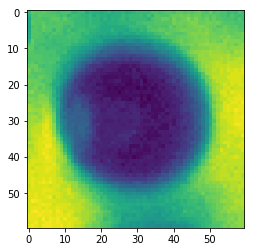

In [795]:
plt.imshow(sub_images[8])

In [796]:
subimg = sub_images[1]
circ = green_bubble_one(subimg, method="peak_dist", max_offset=10)

In [797]:
debug_signals = []
res_circles = []
for idx, subim in enumerate(sub_images):
    circ, signal = green_bubble_one(subim, method="peak_dist", max_offset=10, fit_refine=True)
    debug_signals.append(signal)
    res_circles.append(circ)

C:\Users\windis\Documents\MSc_Habib\gradient_ansatz\utils.py:275: RuntimeWarning: invalid value encountered in sqrt
  


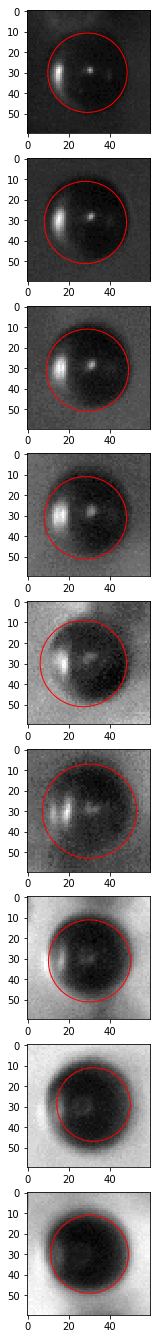

In [798]:
fig, ax = plt.subplots(len(sub_images),1)
fig.set_figheight(24)
for idx, subim in enumerate(sub_images):
    ax[idx].imshow(subim,'gray')
    circ = res_circles[idx]
    ax[idx].add_patch(plt.Circle((circ.x, circ.y), circ.radius, fill=False, color="red"))

In [799]:
radii = [circ.radius for circ in res_circles]

In [800]:
radii

[19.34616557041803,
 20.051310944524246,
 20.022989567645659,
 20.093199531708393,
 21.061903901202186,
 22.97894661756667,
 20.019048180431128,
 17.940576605498791,
 18.98058880548755]

In [801]:
np.mean(radii)

20.05496996938696

In [802]:
np.std(radii)

1.320551284276994

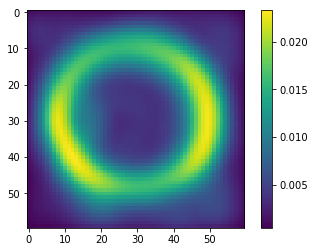

In [708]:
plt.imshow(filters.gaussian(sobel(subim), sigma=3))
plt.colorbar()

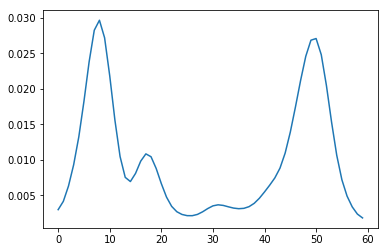

In [699]:
plt.plot(gaussian_filter1d(debug_signals[-1], 2))

## 2. Red bubbles

In [803]:
radii = []
sub_images = []
res_circles = []
for tr in tracks:
    for i in range(len(tr)-1):
        marker = tr[i]
        next_marker = tr[i+1]
        if marker.frame >= 0:
            est_pos_x = (marker.x + next_marker.x)/2
            est_pos_y = (marker.y + next_marker.y)/2
            est_marker = Point(est_pos_x, est_pos_y, marker.frame)
            subimg = extract_pad_image(cim[int(est_marker.frame)-1], 
                                       Point(est_marker.y, est_marker.x), 
                                       window_size=60, 
                                       pad_mode="constant")
            sub_images.append(subimg)
            res_circ = red_bubble_one(subimg)
            res_circles.append(res_circ)
            radii += [res_circ.radius]

fit converged! mu= 4.78176607135
result point =  (56.18210720068371, 40.666981685722924)
samples 0: (51.609190499321912, 39.269226484150266)
len(samples) 10
result point:  (53.521838099864382, 39.853845296830059)
############ new position ############
curr_pos:  (54, 40)
curr_orientation 73.003732491
fit_line= (54, 40) (0.95632380027123587, 0.292309406339894)
(51.609190499321912, 39.269226484150266) 5.25
(52.087352399457529, 39.415381187320214) 5.25
(52.565514299593147, 39.561535890490163) 5.25
(53.043676199728765, 39.707690593660111) 5.26864635886
(53.521838099864382, 39.853845296830059) 5.49185177679
(54.0, 40.000000000000007) 11.5
(54.478161900135618, 40.146154703169955) 5.45690897149
(54.956323800271235, 40.292309406339903) 5.1288751377
(55.434485700406853, 40.438464109509852) 5.23464256321
(55.912647600542471, 40.5846188126798) 5.45262797211
refined_curr_pos= (53.521838099864382, 39.853845296830059)
fit converged! mu= 4.78176607135
result point =  (56.18210720068371, 40.6669816857

C:\Users\windis\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


 (52.999999999999993, 45.000000000000007)
############ new position ############
curr_pos:  (53, 45)
curr_orientation 35.0192734682
fit_line= (53, 45) (0.57385195474650375, 0.81895905516308731)
(51.565370113133739, 42.952602362092279) 6.34010876026
(51.852296090506989, 43.362081889673824) 6.42785623921
(52.13922206788024, 43.77156141725537) 6.61687703759
(52.426148045253491, 44.181040944836916) 6.65606543604
(52.713074022626742, 44.590520472418461) 6.73991498277
(52.999999999999993, 45.000000000000007) 7.0
(53.286925977373244, 45.409479527581553) 6.82589862376
(53.573851954746495, 45.818959055163099) 6.65179724752
(53.860777932119746, 46.228438582744644) 6.526854594
(54.147703909492996, 46.63791811032619) 6.54711149942
refined_curr_pos= (52.999999999999993, 45.000000000000007)
fit converged! mu= 5.80267541191
result point =  (54.537252839295881, 47.941272884663761)
samples 0: (50.818916116066227, 43.486498597606847)
len(samples) 10
result point:  (52.420908498580062, 45.405774608598406

(43.81550750055105, 51.883201749050173) 6.77381246243
(43.974676615346745, 52.357190349013457) 6.75
(44.13384573014244, 52.831178948976742) 6.75564899421
refined_curr_pos= (43.81550750055105, 51.883201749050173)
fit converged! mu= 8.81169926001
result point =  (44.692602037514888, 57.189959648553668)
samples 0: (42.08784199666006, 48.772046072227013)
len(samples) 10
result point:  (43.270251865174131, 52.593290228629556)
############ new position ############
curr_pos:  (42.826848164481362, 51.160323669978595)
curr_orientation 17.1936674458
fit_line= (42.826848164481362, 51.160323669978595) (0.29560246712852112, 0.9553110391006332)
(42.08784199666006, 48.772046072227013) 6.61906851899
(42.235643230224319, 49.249701591777331) 6.69108919244
(42.383444463788578, 49.727357111327649) 6.65413888405
(42.531245697352837, 50.205012630877967) 6.64441659518
(42.679046930917096, 50.682668150428285) 6.69612919537
(42.826848164481355, 51.160323669978602) 6.75694008443
(42.974649398045614, 51.6379791

result point =  (49.710182495880815, 31.550717117106629)
samples 0: (50.207315278494683, 35.049451089344608)
len(samples) 10
result point:  (50.207315278494683, 35.049451089344608)
############ new position ############
curr_pos:  (50.559006145774781, 37.524590183187975)
curr_orientation 8.08698540729
fit_line= (50.559006145774781, 37.524590183187975) (0.14067634691203981, 0.99005563753734738)
(50.207315278494683, 35.049451089344608) 5.58122816186
(50.277653451950705, 35.544478908113284) 5.86439020781
(50.347991625406728, 36.03950672688196) 6.05324814719
(50.41832979886275, 36.534534545650637) 5.75174005581
(50.488667972318773, 37.029562364419313) 5.50377904594
(50.559006145774795, 37.524590183187989) 5.55783526169
(50.629344319230817, 38.019618001956665) 5.58957730067
(50.69968249268684, 38.514645820725342) 5.48505720915
(50.770020666142862, 39.009673639494018) 5.36871411809
(50.840358839598885, 39.504701458262694) 5.54188574611
refined_curr_pos= (50.207315278494683, 35.04945108934460

(56.200871968499193, 36.789860491018068) 5.75
(55.973986661006641, 37.235419754465717) 5.75
(55.74710135351409, 37.680979017913366) 5.75
(55.520216046021538, 38.126538281361015) 5.73482224076
(55.293330738528987, 38.572097544808663) 5.64892906263
(55.066445431036435, 39.017656808256312) 5.51661135776
(54.839560123543883, 39.463216071703961) 5.51857958233
(54.612674816051332, 39.90877533515161) 5.58799789346
(54.38578950855878, 40.354334598599259) 5.68772726553
refined_curr_pos= (55.293330738528987, 38.572097544808663)
fit converged! mu= -2.15752012186
result point =  (58.036892461737438, 34.742559353794846)
samples 0: (57.057873229200375, 36.665165506529576)
len(samples) 10
result point:  (57.057873229200375, 36.665165506529576)
############ new position ############
curr_pos:  (55.92344669173761, 38.892961823767813)
curr_orientation -26.9858612971
fit_line= (55.92344669173761, 38.892961823767813) (-0.45377061498510562, 0.89111852689529414)
(57.057873229200375, 36.665165506529576) 5.75

(50.191104957926569, 48.934253236880153) 5.56107179716
(50.036925004816325, 49.409888120019438) 5.61548706141
(49.882745051706081, 49.885523003158724) 5.70549000806
(49.728565098595837, 50.36115788629801) 5.6408672307
(49.574385145485593, 50.836792769437295) 5.61247381042
refined_curr_pos= (50.191104957926569, 48.934253236880153)
fit converged! mu= 4.50834112039
result point =  (49.029110024972745, 50.664022709010425)
samples 0: (50.127597231941344, 46.291555955112798)
len(samples) 10
result point:  (49.640283970750865, 48.231279075939042)
############ new position ############
curr_pos:  (49.518455655453238, 48.716209856145596)
curr_orientation -14.1024586697
fit_line= (49.518455655453238, 48.716209856145596) (-0.24365663059524312, 0.96986156041312066)
(50.127597231941344, 46.291555955112798) 5.56358855557
(50.005768916643724, 46.776486735319359) 5.69300181202
(49.883940601346104, 47.26141751552592) 5.74374012007
(49.762112286048485, 47.746348295732481) 5.82368838892
(49.6402839707508

curr_orientation -86.548700363
fit_line= (56.083914204126032, 56.406967887566886) (-0.99818632799528773, 0.060200121289611143)
(58.579380024114251, 56.256467584342857) 5.68588310391
(58.080286860116608, 56.286567644987663) 5.67835808875
(57.581193696118966, 56.316667705632469) 5.70398868143
(57.082100532121324, 56.346767766277274) 5.74288254547
(56.583007368123681, 56.37686782692208) 5.75
(56.083914204126039, 56.406967887566886) 5.75
(55.584821040128396, 56.437067948211691) 5.64620526003
(55.085727876130754, 56.467168008856497) 5.52143196903
(54.586634712133112, 56.497268069501303) 5.70611800131
(54.087541548135469, 56.527368130146108) 5.96871536676
refined_curr_pos= (56.083914204126039, 56.406967887566886)
################################### curve [<shapes.Point object at 0x000001D389DF45F8>, <shapes.Point object at 0x000001D3895C40B8>, <shapes.Point object at 0x000001D3889C1B70>, <shapes.Point object at 0x000001D3889E9630>, <shapes.Point object at 0x000001D3889A3AC8>, <shapes.Point o

(36.140711414735762, 4.5340848345877385) 6.48361010448
(36.24297572479508, 5.0235151267520992) 6.5
refined_curr_pos= (35.833918484557806, 3.0657939580946572)
no fit, mu = 5
no fit, direction= <shapes.Point object at 0x000001D3895C46D8>
samples 0: (34.630437977246146, 0.76326607150547421)
len(samples) 10
result point:  (35.141759527542739, 3.2104175323272757)
############ new position ############
curr_pos:  (35.141759527542746, 3.2104175323272761)
curr_orientation 11.8019063167
fit_line= (35.141759527542746, 3.2104175323272761) (0.2045286201186409, 0.97886058432872081)
(34.630437977246146, 0.76326607150547421) 6.58709095599
(34.732702287305464, 1.2526963636698345) 6.54066183183
(34.834966597364783, 1.7421266558341948) 6.38827673616
(34.937230907424102, 2.2315569479985551) 6.26205861827
(35.03949521748342, 2.7209872401629154) 6.25711888696
(35.141759527542739, 3.2104175323272757) 6.28543988189
(35.244023837602057, 3.699847824491636) 6.3110059594
(35.346288147661376, 4.1892781166559967) 

samples 0: (54.695669075922417, 50.180490311164341)
len(samples) 10
result point:  (56.176744394135625, 52.194544903716292)
############ new position ############
curr_pos:  (56.176744394135625, 52.194544903716306)
curr_orientation 36.3296477134
fit_line= (56.176744394135625, 52.194544903716306) (0.59243012728528233, 0.80562183702078494)
(54.695669075922417, 50.180490311164341) 5.75
(54.991884139565059, 50.583301229674731) 5.75
(55.2880992032077, 50.986112148185121) 5.75200053952
(55.584314266850342, 51.388923066695511) 5.65276923333
(55.880529330492983, 51.791733985205902) 5.5520665037
(56.176744394135625, 52.194544903716292) 5.54004004564
(56.472959457778266, 52.597355822226682) 5.57870768411
(56.769174521420908, 53.000166740737072) 5.55773843283
(57.065389585063549, 53.402977659247462) 5.6105041756
(57.361604648706191, 53.805788577757852) 5.71900408272
refined_curr_pos= (56.176744394135625, 52.194544903716292)
no fit, mu = 5
no fit, direction= <shapes.Point object at 0x000001D389ACD

len(samples) 10
result point:  (40.295994882902946, 33.041331705116455)
############ new position ############
curr_pos:  (40.592591014354298, 32.63880129035492)
curr_orientation -36.3838696305
fit_line= (40.592591014354298, 32.63880129035492) (-0.59319226290266991, 0.80506082952309244)
(42.075571671610973, 30.626149216547187) 5.50706313216
(41.778975540159635, 31.028679631308734) 5.49441481718
(41.482379408708297, 31.43121004607028) 5.44799828824
(41.185783277256959, 31.833740460831827) 5.4612762412
(40.889187145805622, 32.23627087559337) 5.52770321355
(40.592591014354284, 32.638801290354913) 5.60185224641
(40.295994882902946, 33.041331705116455) 5.6717853396
(39.999398751451608, 33.443862119877998) 5.63903447003
(39.70280262000027, 33.846392534639541) 5.53840186634
(39.406206488548932, 34.248922949401084) 5.5
refined_curr_pos= (40.295994882902946, 33.041331705116455)
fit converged! mu= 5.68972991643
result point =  (38.131203935355472, 34.787277631184708)
samples 0: (41.5063076997875

fit converged! mu= 5.05069966131
result point =  (45.260097007791799, 55.125674044152639)
samples 0: (45.64922007718333, 50.089986374561846)
len(samples) 10
result point:  (45.45661157960626, 52.582555724983429)
############ new position ############
curr_pos:  (45.456611579606253, 52.582555724983436)
curr_orientation -4.4186402542
fit_line= (45.456611579606253, 52.582555724983436) (-0.077043399030831128, 0.99702774016863549)
(45.64922007718333, 50.089986374561846) 5.67019637268
(45.610698377667916, 50.588500244646163) 5.70995061941
(45.572176678152502, 51.087014114730479) 5.76861333381
(45.533654978637088, 51.585527984814796) 5.88652903029
(45.495133279121674, 52.084041854899112) 5.98121839259
(45.45661157960626, 52.582555724983429) 5.8634171926
(45.418089880090847, 53.081069595067746) 5.75515338419
(45.379568180575433, 53.579583465152062) 5.77009771473
(45.341046481060019, 54.078097335236379) 5.76865048926
(45.302524781544605, 54.576611205320695) 5.82743659276
refined_curr_pos= (45.4

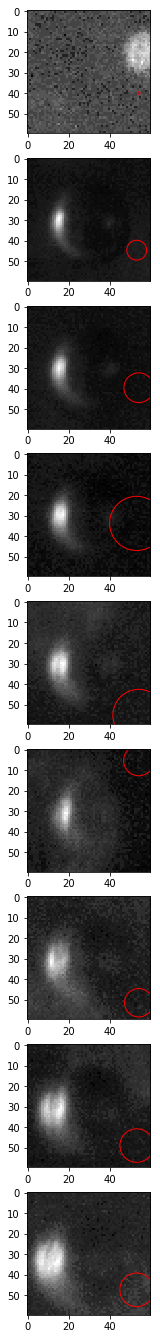

In [804]:
fig, ax = plt.subplots(len(sub_images),1)
fig.set_figheight(24)
for idx, subim in enumerate(sub_images):
    ax[idx].imshow(subim,'gray')
    circ = res_circles[idx]
    ax[idx].add_patch(plt.Circle((circ.x, circ.y), circ.radius, fill=False, color="red"))

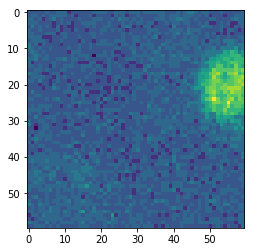

In [780]:
plt.imshow(subimg)

In [769]:
red_bubble_one

1573